In [ ]:
# Librerías base
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt

# Preprocesamiento y modelos
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (
    f1_score,
    average_precision_score,
    roc_auc_score
)

import time
from pprint import pprint

RANDOM_STATE = 42

from IPython.display import display


from utils import *

In [ ]:
df = pd.read_csv("data-churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.shape, df.columns.tolist()

((7043, 21),
 ['customerID',
  'gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'tenure',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'MonthlyCharges',
  'TotalCharges',
  'Churn'])

In [ ]:
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

df["Churn"].value_counts(dropna=False)

Churn
0    5174
1    1869
Name: count, dtype: int64

In [ ]:
# Revisar faltantes
(df.isna().sum().sort_values(ascending=False).head(15))

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [ ]:
target = "Churn"

numeric_features = df.drop(columns=[target]).select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.drop(columns=[target]).select_dtypes(exclude=[np.number]).columns.tolist()



In [ ]:
X = df.drop(columns=[target]).copy()
y = df[target].copy()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['SeniorCitizen', 'tenure', 'MonthlyCharges']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['customerID', 'gender', 'Partner',
                                  'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod',
                                  'TotalCharges'])])

## Paso 2. Árbol de decisión: Grid Search vs Random Search

In [ ]:
pipe_dt = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_dt = {
    "clf__max_depth": [None, 3, 5, 8, 12, 16],
    "clf__min_samples_split": [2, 10, 25, 50],
    "clf__min_samples_leaf": [1, 5, 10, 25],
    "clf__criterion": ["gini", "entropy", "log_loss"]
}

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = "average_precision"  

param_grid_dt

{'clf__max_depth': [None, 3, 5, 8, 12, 16],
 'clf__min_samples_split': [2, 10, 25, 50],
 'clf__min_samples_leaf': [1, 5, 10, 25],
 'clf__criterion': ['gini', 'entropy', 'log_loss']}

In [ ]:
grid_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid=param_grid_dt,
    cv=cv5,
    scoring=scoring,
    n_jobs=-1,
    refit=True,
    return_train_score=False
)

t0 = time.perf_counter()
grid_dt.fit(X, y)
grid_time = time.perf_counter() - t0

print("GridSearchCV time (s):", round(grid_time, 3))
print("Best params (Grid):")
pprint(grid_dt.best_params_)
print("Best score (Grid):", grid_dt.best_score_)

GridSearchCV time (s): 58.077
Best params (Grid):
{'clf__criterion': 'entropy',
 'clf__max_depth': 8,
 'clf__min_samples_leaf': 25,
 'clf__min_samples_split': 2}
Best score (Grid): 0.6175695372935053


In [ ]:
rand_dt = RandomizedSearchCV(
    estimator=pipe_dt,
    param_distributions=param_grid_dt,
    n_iter=50,                 # ajuste según recursos
    cv=cv5,
    scoring=scoring,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True,
    return_train_score=False
)

t0 = time.perf_counter()
rand_dt.fit(X, y)
rand_time = time.perf_counter() - t0

print("RandomizedSearchCV time (s):", round(rand_time, 3))
print("Best params (Random):")
pprint(rand_dt.best_params_)
print("Best score (Random):", rand_dt.best_score_)

RandomizedSearchCV time (s): 9.234
Best params (Random):
{'clf__criterion': 'entropy',
 'clf__max_depth': 8,
 'clf__min_samples_leaf': 25,
 'clf__min_samples_split': 10}
Best score (Random): 0.6175695372935053


In [ ]:
# Comparación directa: tiempos y scores
comparison_search = pd.DataFrame({
    "method": ["GridSearchCV", "RandomizedSearchCV"],
    "time_s": [grid_time, rand_time],
    "best_score(PR-AUC)": [grid_dt.best_score_, rand_dt.best_score_]
}).sort_values("best_score(PR-AUC)", ascending=False)

comparison_search

,method,time_s,best_score(PR-AUC)
0,GridSearchCV,58.077191,0.61757
1,RandomizedSearchCV,9.233720,0.61757


### 2.3 Evaluación final del mejor árbol (CV)


Mejor método: GridSearchCV
Mejores hiperparámetros:
{'clf__criterion': 'entropy',
 'clf__max_depth': 8,
 'clf__min_samples_leaf': 25,
 'clf__min_samples_split': 2}


,fold,fit_time_s,pred_time_s,accuracy,precision,recall,f1,auc_roc,pr_auc
0,1,0.165293,0.027792,0.789212,0.608451,0.577540,0.592593,0.828351,0.631010
1,2,0.159935,0.028471,0.785664,0.606509,0.548128,0.575843,0.817486,0.616146
2,3,0.178154,0.030616,0.797729,0.639498,0.545455,0.588745,0.827300,0.650971
3,4,0.161203,0.029573,0.774858,0.590323,0.490617,0.535871,0.799156,0.560033
4,5,0.177614,0.032561,0.793324,0.631746,0.532086,0.577649,0.822886,0.629687


,mean,std
fit_time_s,0.168440,0.008848
pred_time_s,0.029803,0.001880
accuracy,0.788157,0.008696
precision,0.615305,0.020026
recall,0.538765,0.031618
f1,0.574140,0.022547
auc_roc,0.819036,0.011911
pr_auc,0.617570,0.034481



Matriz de confusión (global):
[[4544  630]
 [ 862 1007]]

Classification report (global):
              precision    recall  f1-score   support

           0      0.841     0.878     0.859      5174
           1      0.615     0.539     0.574      1869

    accuracy                          0.788      7043
   macro avg      0.728     0.709     0.717      7043
weighted avg      0.781     0.788     0.783      7043



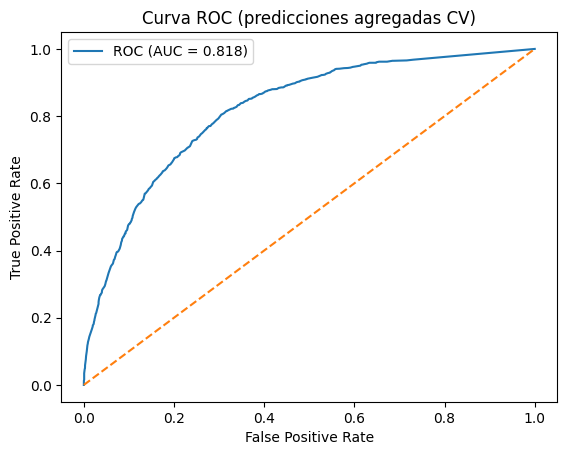

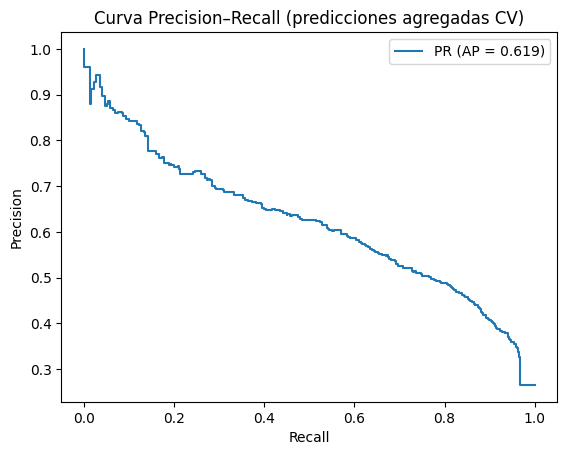

In [ ]:
# Elegir el mejor entre Grid y Random por score
best_dt_search = grid_dt #Verificar
best_dt = best_dt_search.best_estimator_

print("Mejor método:", type(best_dt_search).__name__)
print("Mejores hiperparámetros:")
pprint(best_dt_search.best_params_)

df_dt, summary_dt, curves_dt = evaluate_model_cv_detailed(best_dt, X, y, cv=cv5, plot_curves=True, verbose=True)

## Paso 3. Visualización del árbol óptimo

In [ ]:
# Entrenar el mejor árbol en todo el dataset para visualizarlo
best_dt.fit(X, y)

dt_clf = best_dt.named_steps["clf"]
feature_names = get_feature_names_from_preprocessor(best_dt.named_steps["preprocess"])

len(feature_names), feature_names[:10]

(13618,
 ['num__SeniorCitizen',
  'num__tenure',
  'num__MonthlyCharges',
  'cat__customerID_0002-ORFBO',
  'cat__customerID_0003-MKNFE',
  'cat__customerID_0004-TLHLJ',
  'cat__customerID_0011-IGKFF',
  'cat__customerID_0013-EXCHZ',
  'cat__customerID_0013-MHZWF',
  'cat__customerID_0013-SMEOE'])

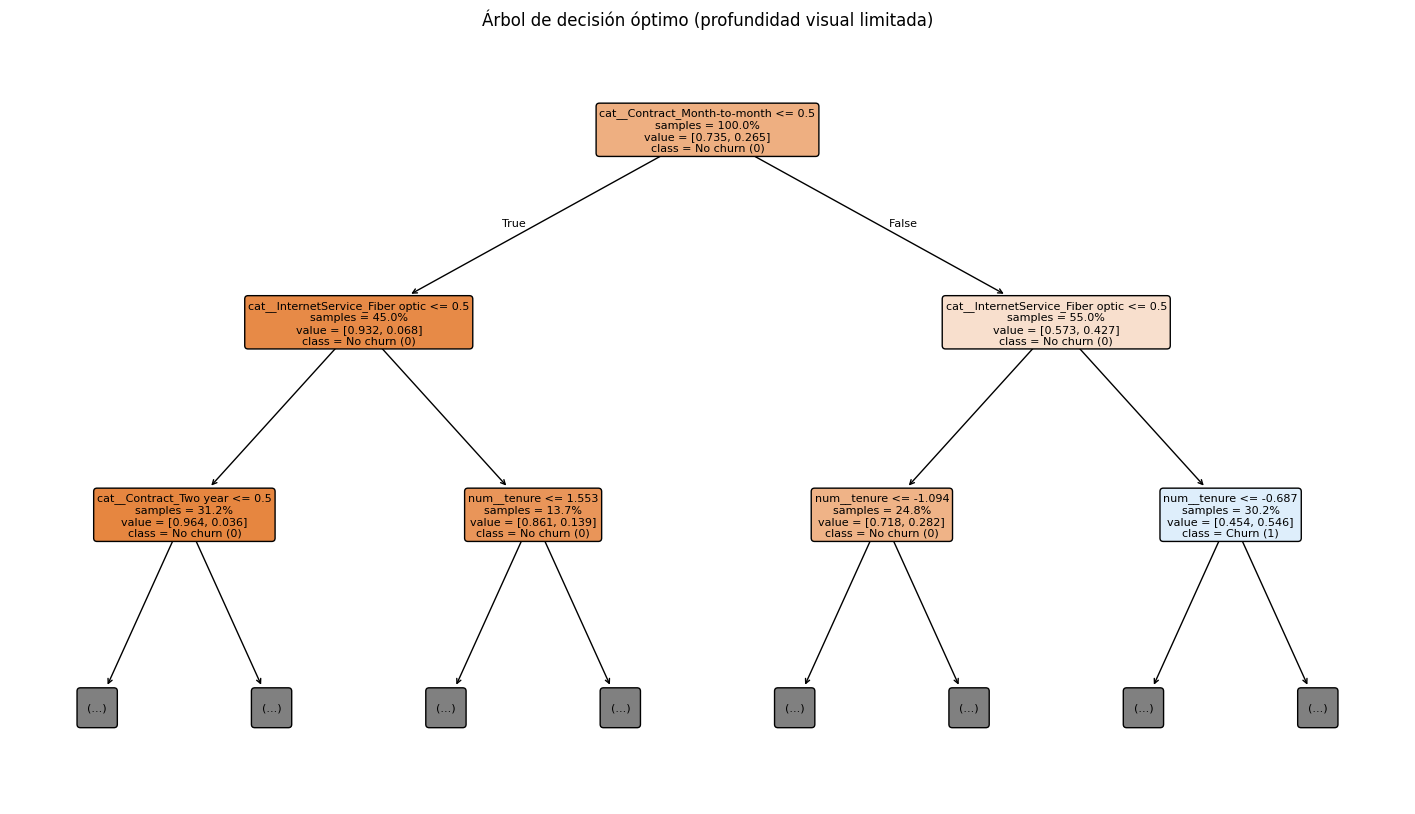

In [ ]:
plt.figure(figsize=(18, 10))
plot_tree(
    dt_clf,
    feature_names=feature_names,
    class_names=["No churn (0)", "Churn (1)"],
    filled=True,
    max_depth=2,           # ajustar según legibilidad
    impurity=False,
    proportion=True,
    rounded=True,
    fontsize=8
)
plt.title("Árbol de decisión óptimo (profundidad visual limitada)")
plt.show()

## Paso 5. Selección del mejor Random Forest (optimización de hiperparámetros)

In [ ]:
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid_rf = {
    "clf__n_estimators": [32, 64, 128, 256],
    "clf__max_depth": [None, 5, 10, 15],
    "clf__min_samples_leaf": [1, 5, 10],
    "clf__max_features": ["sqrt", "log2", None],
    "clf__class_weight": [None, "balanced"]
}

# Random Search recomendado para reducir tiempo
rand_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_grid_rf,
    n_iter=40,
    cv=cv5,
    scoring=scoring,   # PR-AUC
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True,
    return_train_score=False
)

t0 = time.perf_counter()
rand_rf.fit(X, y)
rf_time = time.perf_counter() - t0

print("RandomizedSearchCV RF time (s):", round(rf_time, 3))
print("Best params (RF):")
pprint(rand_rf.best_params_)
print("Best score (RF, PR-AUC):", rand_rf.best_score_)

RandomizedSearchCV RF time (s): 125.447
Best params (RF):
{'clf__class_weight': 'balanced',
 'clf__max_depth': 10,
 'clf__max_features': None,
 'clf__min_samples_leaf': 10,
 'clf__n_estimators': 128}
Best score (RF, PR-AUC): 0.6553181009919834


,fold,fit_time_s,pred_time_s,accuracy,precision,recall,f1,auc_roc,pr_auc
0,1,2.031593,0.067762,0.777147,0.559761,0.751337,0.641553,0.857162,0.683503
1,2,1.878693,0.064537,0.762952,0.539683,0.727273,0.619590,0.838026,0.650729
2,3,1.916190,0.066644,0.779276,0.564155,0.740642,0.640462,0.849014,0.678224
3,4,1.873381,0.076628,0.761364,0.537525,0.710456,0.612009,0.824375,0.608196
4,5,1.874757,0.067697,0.759233,0.535211,0.711230,0.610792,0.838972,0.655938


,mean,std
fit_time_s,1.914923,0.067574
pred_time_s,0.068654,0.004645
accuracy,0.767994,0.009450
precision,0.547267,0.013593
recall,0.728187,0.017985
f1,0.624881,0.015107
auc_roc,0.841510,0.012385
pr_auc,0.655318,0.029837



Matriz de confusión (global):
[[4048 1126]
 [ 508 1361]]

Classification report (global):
              precision    recall  f1-score   support

           0      0.888     0.782     0.832      5174
           1      0.547     0.728     0.625      1869

    accuracy                          0.768      7043
   macro avg      0.718     0.755     0.728      7043
weighted avg      0.798     0.768     0.777      7043



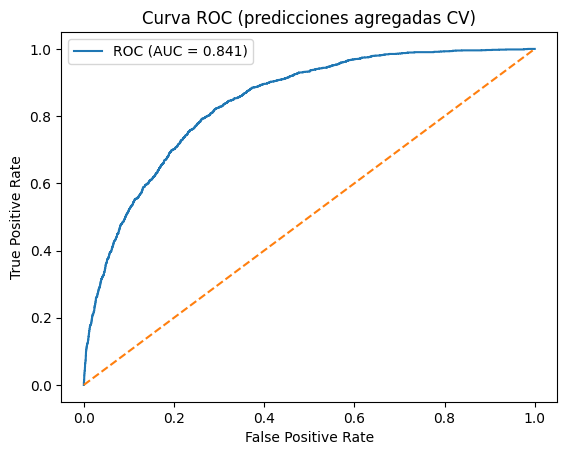

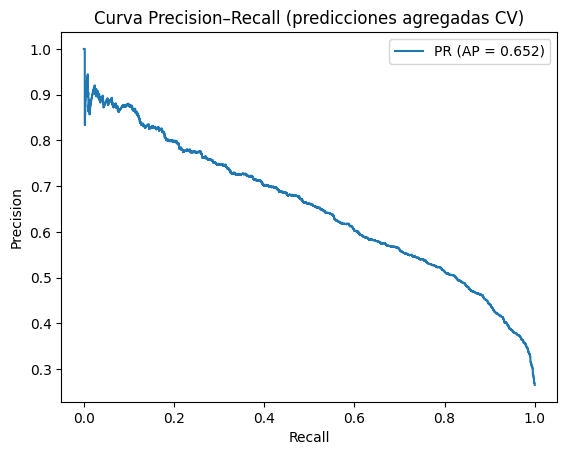

In [ ]:
best_rf = rand_rf.best_estimator_
df_rf, summary_rf, curves_rf = evaluate_model_cv_detailed(best_rf, X, y, cv=cv5, plot_curves=True, verbose=True)

## Paso 6. Comparación final: Árbol vs Random Forest

In [ ]:
# Resumen comparativo (métricas promedio)
summary_dt_comp = summary_dt.copy()
summary_dt_comp["model"] = "DecisionTree (best)"
summary_rf_comp = summary_rf.copy()
summary_rf_comp["model"] = "RandomForest (best)"

summary_all = pd.concat([summary_dt_comp.reset_index().rename(columns={"index":"metric"}),
                         summary_rf_comp.reset_index().rename(columns={"index":"metric"})],
                        ignore_index=True)

# Ordenar para lectura
summary_all = summary_all[["model","metric","mean","std"]].sort_values(["metric","model"])
summary_all

,model,metric,mean,std
2,DecisionTree (best),accuracy,0.788157,0.008696
10,RandomForest (best),accuracy,0.767994,0.009450
6,DecisionTree (best),auc_roc,0.819036,0.011911
14,RandomForest (best),auc_roc,0.841510,0.012385
5,DecisionTree (best),f1,0.574140,0.022547
13,RandomForest (best),f1,0.624881,0.015107
0,DecisionTree (best),fit_time_s,0.168440,0.008848
8,RandomForest (best),fit_time_s,1.914923,0.067574
7,DecisionTree (best),pr_auc,0.617570,0.034481
15,RandomForest (best),pr_auc,0.655318,0.029837


## Paso 7. Discusión y conclusiones
1. Justificación de rangos de hiperparámetros (overfitting, complejidad, interpretabilidad).
2. Comparación Grid vs Random (tiempo y score).
3. Interpretación de splits más relevantes del árbol.
4. Análisis de varianza en Random Forest y su relación con bagging.
5. Métrica prioritaria para retención (desde perspectiva de negocio) y por qué.
